# Notebook 022: Build Model Features

This notebook combines features from the cleansed crime incidents dataset as well as a number of other datasets to append each crime incident record with the additional engineered features used in our analysis.

## Contents

This notebook contains the following high-level sections:

1. Read in various source datasets (all examined and cleansed in prior notebooks)
1. Merge City of Boston property assessment engineered features
1. Merge NOAA climatological daily weather features
1. Generate a `night` feature using NOAA daily sunrise/sunset times
1. Generate a streetlight density feature using City of Boston streetlight locational data
1. Generate a college or university proximity feature using related City of Boston locational data
1. Generate a highschool proximity feature using related City of Boston public and non-public schools locational data
1. Merge U.S. census-based neighborhood demographic data originated from the 5-year American Community Survey (ACS)
1. Drop unwanted columns and observations with missing predictor values
1. Generate train-test-split of the dataset
1. Generate a version of the dataset with standardized (i.e. scaled) quantitative, non-binary features
1. Generate a `streetlight-night` interaction term to include in our analysis
1. Sort column order of final dataset and save to disk

## Notebook Output

This notebook outputs the following .csv files:

1. **X_train.csv**
1. **X_test.csv**
1. **X_train_scaled.csv** (all non-binary predictors are standardized, fitted using X_train) 
1. **X_test_scaled.csv** (all non-binary predictors are standardized, fitted using X_train)
1. **y_train.csv**
1. **y_test.csv**
1. **X_scaler.csv** (this has the predictor-by-predictor means and stds required to restore the scaled datasets to their original values)

## Data Sources

All original datasources underlying these engineered features can be found online at various sites. To view a full list of data sources investigated and used, please refer to the `data-inventory.csv` file accessible here:
https://github.com/sedelmeyer/predicting-crime/blob/master/data-inventory.csv

## Instructions

To download the original datasources yourself and replicate the underlying cleansed and enhanced datasets merged here you can clone the GitHub repository found here and follow the "Getting Started" instructions available in the `README.md` file: https://github.com/sedelmeyer/predicting-crime


In [1]:
import urllib
import os
import operator
import pathlib
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
DATA_ROOT = '../data/'
FIGURES_ROOT = '../figures/crime'

READDIR_ROOT = os.path.join(DATA_ROOT, 'raw')
WRITEDIR_ROOT = os.path.join(DATA_ROOT, 'interim/crime')
FEATURES_ROOT = os.path.join(DATA_ROOT, 'processed')

readfile_crime = os.path.join(FEATURES_ROOT, 'crime-records-for-model-no-features-added.csv')
readfile_property = os.path.join(FEATURES_ROOT, 'property-assessment-features-2013-2019.csv')
readfile_weather = os.path.join(FEATURES_ROOT, 'boston-daily-weather-20140101-20190831.csv')
readfile_streetlights = os.path.join(READDIR_ROOT, 'boston/streetlights.csv')
readfile_demographics = os.path.join(DATA_ROOT, 'interim/demographics_master_neighborhood.csv')
readfile_colleges = os.path.join(FEATURES_ROOT, 'colleges_universities_final.csv')
readfile_schools_public = os.path.join(READDIR_ROOT, 'boston/public-k12-schools.csv')
readfile_schools_nonpublic = os.path.join(READDIR_ROOT, 'boston/nonpublic-k12-schools.csv')

readfile_zipshapes = os.path.join(READDIR_ROOT, 'shapefile/zipcodes/ZIP_Codes.shp')
readfile_cityshape = os.path.join(READDIR_ROOT, 'shapefile/city-boundary/City_of_Boston_Boundary.shp')
readfile_streetshapes = os.path.join(READDIR_ROOT, 'shapefile/street-segments/Boston_Street_Segments.shp')
readfile_tractshapes = os.path.join(READDIR_ROOT, 'shapefile/census-tracts/Census_2010_Tracts.shp')
readfile_hoodshapes = os.path.join(READDIR_ROOT, 'shapefile/boston-neighborhoods/Boston_Neighborhoods.shp')
readfile_zonesubshapes = os.path.join(READDIR_ROOT, 'shapefile/zoning-subdistricts/Zoning_Subdistricts.shp')
readfile_openshapes = os.path.join(READDIR_ROOT, 'shapefile/open-spaces/Open_Space.shp')

print(
    'readfile paths for datasets used in this notebook are:\n\t{}\n\t{}\n\t{}'.format(
        readfile_crime, readfile_property, readfile_weather, readfile_zipshapes, WRITEDIR_ROOT
    )
)

readfile paths for datasets used in this notebook are:
	../data/processed/crime-records-for-model-no-features-added.csv
	../data/processed/property-assessment-features-2013-2019.csv
	../data/processed/boston-daily-weather-20140101-20190831.csv


## Read in datasources for merging

In [3]:
df_crime = pd.read_csv(readfile_crime, dtype=str)
df_property = pd.read_csv(readfile_property, dtype={'shape-id': str, 'fiscal-year': int})
df_weather = pd.read_csv(readfile_weather)
df_lights = pd.read_csv(readfile_streetlights)
df_colleges = pd.read_csv(readfile_colleges)
df_schoolspub = pd.read_csv(readfile_schools_public)
df_schoolsnonpub = pd.read_csv(readfile_schools_nonpublic)
df_demographics = pd.read_csv(readfile_demographics)

df_crime['lat'] = df_crime['lat'].astype(float)
df_crime['lon'] = df_crime['lon'].astype(float)

In [4]:
# print info for each dataframe
print('CRIME DATAFRAME\n')
df_crime.info()
display(df_crime.head())

CRIME DATAFRAME

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162533 entries, 0 to 162532
Data columns (total 18 columns):
crime-type             162533 non-null object
INCIDENT_NUMBER        162533 non-null object
OFFENSE_DESCRIPTION    162533 non-null object
timestamp              162533 non-null object
lat                    162533 non-null float64
lon                    162533 non-null float64
year                   162533 non-null object
month                  162533 non-null object
day-of-week            162533 non-null object
hour                   162533 non-null object
ZIP5                   162509 non-null object
ZIP5_area              162509 non-null object
Name                   162460 non-null object
Neighborhood_area      162460 non-null object
Neighborhood_area_2    162460 non-null object
TRACTCE10              162533 non-null object
TRACTCE10_area         162533 non-null object
TRACTCE10_area_2       162533 non-null object
dtypes: float64(2), object(16)
memory usag

,crime-type,INCIDENT_NUMBER,OFFENSE_DESCRIPTION,timestamp,lat,lon,year,month,day-of-week,hour,ZIP5,ZIP5_area,Name,Neighborhood_area,Neighborhood_area_2,TRACTCE10,TRACTCE10_area,TRACTCE10_area_2
0,fraud,I192078177,forgery / counterfeiting,2019-08-01 17:46:00,42.304922,-71.102981,2019,8,Thursday,17,02130,105221153.02392578,Roxbury,91844545.97481573,3.29,980300,22640579.7627,3847996.3515625
1,harassment-disturbance,I192078061,harassment,2019-06-12 21:00:00,42.355553,-71.152747,2019,6,Wednesday,21,02135,78620825.92480469,Brighton,80167877.560494,2.88,000202,6475526.5708,1102312.71484375
2,theft,I192078038,larceny theft of mv parts & accessories,2019-03-10 08:00:00,42.345625,-71.041291,2019,3,Sunday,8,02210,32373210.07080078,South Boston Waterfront,27087395.391558826,0.97,060600,20379799.0356,3468813.69921875
3,theft,I192078015,larceny all others,2019-07-08 10:29:00,42.339304,-71.051604,2019,7,Monday,10,02127,67536142.7421875,South Boston,62721306.143917084,2.25,060700,1380119.5437,234830.15234375
4,theft,I192077997,auto theft - leased/rented vehicle,2019-04-13 08:00:00,42.328564,-71.068353,2019,4,Saturday,8,02119,44511498.52441406,Roxbury,91844545.97481573,3.29,080100,11047170.5891,1879154.8203125


## One-hot-encode categorical features and create response categories

In [5]:
# print summary value counts for comparison after mapping values
print(df_crime['day-of-week'].value_counts(dropna=False))
print()
print(df_crime['month'].value_counts(dropna=False))
print()
print(df_crime['crime-type'].value_counts(dropna=False).sort_index())
print()

Friday       24492
Wednesday    23742
Thursday     23629
Saturday     23361
Monday       23184
Tuesday      23151
Sunday       20974
Name: day-of-week, dtype: int64

8     16179
7     16044
6     15659
5     15536
1     14385
4     14295
3     14006
2     12711
9     11508
10    11496
11    10460
12    10254
Name: month, dtype: int64

burglary                   7156
drugs-substances          16527
fraud                     12126
harassment-disturbance    26276
other                      8083
robbery                    4317
theft                     43756
vandalism-property        17353
violence-aggression       26939
Name: crime-type, dtype: int64



In [6]:
# create dictionaries required for one-hot-encoding
# and mapping categorical values
months_dict = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec',
}

# assign numeric categories to our response variable categories
crime_type_dict = {
    'other': 0,
    'burglary': 1,
    'drugs-substances': 2,
    'fraud': 3,
    'harassment-disturbance': 4,
    'robbery': 5,
    'theft': 6,
    'vandalism-property': 7,
    'violence-aggression': 8,
}

###################################################
## MAP MONTHS DATA AND RESPONSE VARIABLE CATEGORIES
###################################################

df_crime['month'] = df_crime['month'].astype(int)
df_crime['crime-type-cat'] = df_crime['crime-type'].copy()
df_crime['month-cat'] = df_crime['month'].copy().map(months_dict)
df_crime['crime-type'] = df_crime['crime-type-cat'].copy().map(crime_type_dict)

# print mapping results
print(df_crime['month-cat'].value_counts(dropna=False))
print()
print(df_crime['crime-type'].value_counts(dropna=False).sort_index())
print()

Aug    16179
Jul    16044
Jun    15659
May    15536
Jan    14385
Apr    14295
Mar    14006
Feb    12711
Sep    11508
Oct    11496
Nov    10460
Dec    10254
Name: month-cat, dtype: int64

0     8083
1     7156
2    16527
3    12126
4    26276
5     4317
6    43756
7    17353
8    26939
Name: crime-type, dtype: int64



In [7]:
# define order for sorting month columns once they are one-hot-encoded
months_col_order = list(months_dict.values())[1:]

# define order for sorting one-hot-encoded weekday columns
weekdays_list = [
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday',
    'Sunday',
]

# one-hot-encode categorical predictors day of week and month
weekday_dummies_df = pd.get_dummies(df_crime['day-of-week']).drop(columns='Monday')[weekdays_list]
month_dummies_df = pd.get_dummies(df_crime['month-cat']).drop(columns='Jan')[months_col_order]

# append dummy columns to full dataframe in desired order
df_crime[weekdays_list] = weekday_dummies_df[weekdays_list]
df_crime[months_col_order] = month_dummies_df[months_col_order]

In [8]:
# print summary info to confirm resulting dataframe
# print summary info on this model data
print(df_crime.columns)
df_crime.head()

Index(['crime-type', 'INCIDENT_NUMBER', 'OFFENSE_DESCRIPTION', 'timestamp',
       'lat', 'lon', 'year', 'month', 'day-of-week', 'hour', 'ZIP5',
       'ZIP5_area', 'Name', 'Neighborhood_area', 'Neighborhood_area_2',
       'TRACTCE10', 'TRACTCE10_area', 'TRACTCE10_area_2', 'crime-type-cat',
       'month-cat', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec'],
      dtype='object')


,crime-type,INCIDENT_NUMBER,OFFENSE_DESCRIPTION,timestamp,lat,lon,year,month,day-of-week,hour,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,3,I192078177,forgery / counterfeiting,2019-08-01 17:46:00,42.304922,-71.102981,2019,8,Thursday,17,...,0,0,0,0,0,1,0,0,0,0
1,4,I192078061,harassment,2019-06-12 21:00:00,42.355553,-71.152747,2019,6,Wednesday,21,...,0,0,0,1,0,0,0,0,0,0
2,6,I192078038,larceny theft of mv parts & accessories,2019-03-10 08:00:00,42.345625,-71.041291,2019,3,Sunday,8,...,1,0,0,0,0,0,0,0,0,0
3,6,I192078015,larceny all others,2019-07-08 10:29:00,42.339304,-71.051604,2019,7,Monday,10,...,0,0,0,0,1,0,0,0,0,0
4,6,I192077997,auto theft - leased/rented vehicle,2019-04-13 08:00:00,42.328564,-71.068353,2019,4,Saturday,8,...,0,1,0,0,0,0,0,0,0,0


## Merge property assessment features

In [9]:
print('\n\nPROPERTY ASSESSMENT FEATURES DATAFRAME\n')
df_property.info()
display(df_property.head())



PROPERTY ASSESSMENT FEATURES DATAFRAME

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13002 entries, 0 to 13001
Data columns (total 5 columns):
shape-id       13002 non-null object
fiscal-year    13002 non-null int64
value          12927 non-null float64
shape-type     13002 non-null object
metric         13002 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 508.0+ KB


,shape-id,fiscal-year,value,shape-type,metric
0,00000,2013,37000.0,zipcode,residential-median-value
1,02026,2013,NaN,zipcode,residential-median-value
2,02108,2013,691300.0,zipcode,residential-median-value
3,02109,2013,456950.0,zipcode,residential-median-value
4,02110,2013,566512.5,zipcode,residential-median-value


In [10]:
# subset property features data to contain only census-tract level metrics
df_property = df_property.loc[df_property['shape-type']=='census tract']
df_property.shape

(9570, 5)

In [11]:
# make list of metrics for matching
print(df_property['metric'].value_counts())

prop_metrics_list = list(df_property['metric'].value_counts().index)

print()
print(prop_metrics_list)

commercial-mix-ratio                 1267
industrial-mix-ratio                 1267
owner-occupied-ratio                 1190
residential-gini-coef                1183
residential-median-value             1183
commercial-mix-ratio-3yr-cagr         724
industrial-mix-ratio-3yr-cagr         724
owner-occupied-ratio-3yr-cagr         680
residential-median-value-3yr-cagr     676
residential-gini-coef-3yr-cagr        676
Name: metric, dtype: int64

['commercial-mix-ratio', 'industrial-mix-ratio', 'owner-occupied-ratio', 'residential-gini-coef', 'residential-median-value', 'commercial-mix-ratio-3yr-cagr', 'industrial-mix-ratio-3yr-cagr', 'owner-occupied-ratio-3yr-cagr', 'residential-median-value-3yr-cagr', 'residential-gini-coef-3yr-cagr']


In [12]:
# create temporary match-key column for crime dataset record matching
df_crime['tract-match-key'] = (df_crime['TRACTCE10'].astype(str) + df_crime['year'].astype(str)).values

df_crime['tract-match-key'].head()

0    9803002019
1    0002022019
2    0606002019
3    0607002019
4    0801002019
Name: tract-match-key, dtype: object

In [13]:
# Start list of "temporary match" column names for dropping before saving final dataframe

temp_drop_list = ['tract-match-key']

In [14]:
# create equivalent match-key column for property metrics dataframe
df_property['shape_match'] = (df_property['shape-id'].astype(str) + df_property['fiscal-year'].astype(str)).values
df_property.head()

,shape-id,fiscal-year,value,shape-type,metric,shape_match
420,000100,2013,402150.0,census tract,residential-median-value,0001002013
421,000201,2013,444900.0,census tract,residential-median-value,0002012013
422,000202,2013,447581.0,census tract,residential-median-value,0002022013
423,000301,2013,412700.0,census tract,residential-median-value,0003012013
424,000302,2013,326650.0,census tract,residential-median-value,0003022013


In [15]:
############################################
# Merge property features to crime dataframe
############################################

for metric in prop_metrics_list:
    temp_match_dict = dict(
        zip(
            df_property.loc[df_property['metric']==metric][['value', 'shape_match']].values[:,1],
            df_property.loc[df_property['metric']==metric][['value', 'shape_match']].values[:,0]
        )
    )
    df_crime[metric] = df_crime['tract-match-key'].copy().map(temp_match_dict)

In [16]:
# view resulting dataframe with added property features
print(df_crime.info())
df_crime.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162533 entries, 0 to 162532
Data columns (total 48 columns):
crime-type                           162533 non-null int64
INCIDENT_NUMBER                      162533 non-null object
OFFENSE_DESCRIPTION                  162533 non-null object
timestamp                            162533 non-null object
lat                                  162533 non-null float64
lon                                  162533 non-null float64
year                                 162533 non-null object
month                                162533 non-null int64
day-of-week                          162533 non-null object
hour                                 162533 non-null object
ZIP5                                 162509 non-null object
ZIP5_area                            162509 non-null object
Name                                 162460 non-null object
Neighborhood_area                    162460 non-null object
Neighborhood_area_2                  162460 non-n

,crime-type,INCIDENT_NUMBER,OFFENSE_DESCRIPTION,timestamp,lat,lon,year,month,day-of-week,hour,...,commercial-mix-ratio,industrial-mix-ratio,owner-occupied-ratio,residential-gini-coef,residential-median-value,commercial-mix-ratio-3yr-cagr,industrial-mix-ratio-3yr-cagr,owner-occupied-ratio-3yr-cagr,residential-median-value-3yr-cagr,residential-gini-coef-3yr-cagr
0,3,I192078177,forgery / counterfeiting,2019-08-01 17:46:00,42.304922,-71.102981,2019,8,Thursday,17,...,0.000000,0.000294,0.000000,0.000000,756500.0,0.000000,-0.034814,0.000000,0.024264,0.000000
1,4,I192078061,harassment,2019-06-12 21:00:00,42.355553,-71.152747,2019,6,Wednesday,21,...,0.069416,0.000000,0.550355,0.199606,745950.0,-0.010424,0.000000,-0.028224,0.068142,0.011166
2,6,I192078038,larceny theft of mv parts & accessories,2019-03-10 08:00:00,42.345625,-71.041291,2019,3,Sunday,8,...,0.478130,0.000938,0.456287,0.228793,538500.0,0.010549,-0.084828,-0.014131,0.060340,0.018436
3,6,I192078015,larceny all others,2019-07-08 10:29:00,42.339304,-71.051604,2019,7,Monday,10,...,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
4,6,I192077997,auto theft - leased/rented vehicle,2019-04-13 08:00:00,42.328564,-71.068353,2019,4,Saturday,8,...,0.375058,0.076862,0.460751,0.172898,355500.0,-0.007779,0.060168,-0.023444,0.082123,0.025972


## Merge weather data features

In [17]:
print('\n\nWEATHER FEATURES DATAFRAME\n')
df_weather.info()
display(df_weather.head())



WEATHER FEATURES DATAFRAME

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 13 columns):
date            1339 non-null object
weathercodes    660 non-null object
sunrise         1339 non-null int64
sunset          1339 non-null int64
tempavg         1339 non-null float64
tempmax         1339 non-null float64
tempmin         1339 non-null float64
humavg          1338 non-null float64
windavg         1339 non-null float64
windsustain     1339 non-null int64
windmax         1339 non-null int64
precip          1339 non-null float64
snowfall        1339 non-null float64
dtypes: float64(7), int64(4), object(2)
memory usage: 136.1+ KB


,date,weathercodes,sunrise,sunset,tempavg,tempmax,tempmin,humavg,windavg,windsustain,windmax,precip,snowfall
0,2016-01-01,NaN,713,1622,2.8,5.0,0.6,58.0,12.7,23,32,0.0,0.0
1,2016-01-02,NaN,714,1623,2.2,4.4,-0.6,53.0,13.3,22,28,0.0,0.0
2,2016-01-03,NaN,714,1624,3.3,6.7,-0.6,57.0,11.7,21,28,0.0,0.0
3,2016-01-04,SN,714,1625,-3.9,2.2,-10.0,59.0,12.4,21,28,0.0,0.0
4,2016-01-05,NaN,714,1626,-8.3,-3.3,-13.3,41.0,10.0,18,23,0.0,0.0


In [18]:
# create temporary date match column and add to drop list
temp_drop_list = temp_drop_list + ['date']

df_crime['date'] = df_crime['timestamp'].str[:10]

In [19]:
# create list of weather-related column names for later manipulation
weather_match_cols = df_weather.columns

weather_match_cols

Index(['date', 'weathercodes', 'sunrise', 'sunset', 'tempavg', 'tempmax',
       'tempmin', 'humavg', 'windavg', 'windsustain', 'windmax', 'precip',
       'snowfall'],
      dtype='object')

In [20]:
# keep only desired weather features and those required for merging
weather_match_cols = ['date', 'weathercodes', 'sunrise', 'sunset', 'tempavg',
       'windavg', 'precip', 'snowfall']

In [21]:
# merge weather values to crime data 
df_crime = df_crime.merge(df_weather[weather_match_cols], how='left', on='date')

# print results
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162533 entries, 0 to 162532
Data columns (total 56 columns):
crime-type                           162533 non-null int64
INCIDENT_NUMBER                      162533 non-null object
OFFENSE_DESCRIPTION                  162533 non-null object
timestamp                            162533 non-null object
lat                                  162533 non-null float64
lon                                  162533 non-null float64
year                                 162533 non-null object
month                                162533 non-null int64
day-of-week                          162533 non-null object
hour                                 162533 non-null object
ZIP5                                 162509 non-null object
ZIP5_area                            162509 non-null object
Name                                 162460 non-null object
Neighborhood_area                    162460 non-null object
Neighborhood_area_2                  162460 non-n

## Create night time feature using sunrise and sunset data from weather merge

In [22]:
# convert timestamp to datetime data type for ease of use
df_crime['timestamp'] = pd.to_datetime(df_crime['timestamp'])

# create time values for each record in minutes
df_crime['time'] = (df_crime['timestamp'].dt.hour * 60) + df_crime['timestamp'].dt.minute

In [23]:
# create night time indicator feature
df_crime['night'] = (
    (df_crime['time'] < df_crime['sunrise']) | (df_crime['time'] > df_crime['sunset'])
).astype(int)

In [24]:
# check results
df_crime[['timestamp', 'year', 'month', 'hour', 'time', 'sunrise', 'sunset', 'night']].head()

,timestamp,year,month,hour,time,sunrise,sunset,night
0,2019-08-01 17:46:00,2019,8,17,1066,436,1904,0
1,2019-06-12 21:00:00,2019,6,21,1260,407,1921,0
2,2019-03-10 08:00:00,2019,3,8,480,605,1744,1
3,2019-07-08 10:29:00,2019,7,10,629,415,1923,0
4,2019-04-13 08:00:00,2019,4,8,480,507,1823,1


In [25]:
# add additional columns to drop prior to saving
temp_drop_list = temp_drop_list + ['time', 'sunrise', 'sunset']

## Create streetlight density feature

In [26]:
def distance(locs1, locs2, r=6371, meters=True):
    """
    Converts distances between lat/lon points to meters using the Haversine
    formula for measuring distance on a sphere

    If the desire is to measure pairwise distances between two coordinate
    arrays of equal length, or between two single sets of coordinates, this
    function can simply be called as `distance(locs1, locs2)`

    If the desire is to measure the distances of each coordinate in array 1
    all coordinates in array 2, the function needs to be called in this
    manner `distance(locs1[:, None], locs2)`
    
    locs1: np.array or list of lat/lon points
    locs2: np.array or list of lat/lon points
    r: float, default=6371, great sphere approximated radius of the earth
       in kilometers
    meters: boolean, default=True, specifies the output
            units of the distances returned by this function, meters if True,
            and kilometers if False
    
    returns: np.array of the distances between coordinates in either meters
             or kilometers
    """
    if meters:
        r = r * 1000
    
    # convert lat/lon coordinates to radians
    locs1 = locs1 * np.pi / 180
    locs2 = locs2 * np.pi / 180
    
    cos_lat1 = np.cos(locs1[..., 0])
    cos_lat2 = np.cos(locs2[..., 0])
    
    cos_lat_d = np.cos(locs1[..., 0] - locs2[..., 0])
    cos_lon_d = np.cos(locs1[..., 1] - locs2[..., 1])
    
    a = (1 - cos_lat_d)/2 + cos_lat1 * cos_lat2 * (1 - cos_lon_d)/2
    
    return 2 * r * np.arcsin(np.sqrt(a))

In [27]:
# test distance between widener and boston city hall to confirm
# distance function is working correctly
test_1 = np.array((42.373392, -71.116507))
test_2 = np.array((42.360126, -71.059320))

distance(test_2, test_1)

4924.382348283844

In [28]:
# convert crime locations and streetlight locations to numpy arrays
crime_locs = df_crime[['lat','lon']].values
light_locs = df_lights[['Lat', 'Long']].values

In [29]:
%%time
threshold = 100 # distance in meters
n_splits = 155 # split into batches to prevent memory allocation issues
splits = np.array_split(crime_locs, n_splits)

#calculate streetlight densities, and use tqdm to track progress
for i, split in tqdm(enumerate(splits)):
    distances = distance(split[:, None], light_locs)
    densities = np.sum((distances<threshold).astype(int), axis=1).reshape(-1,1)
    if i == 0:
        streetlights = densities.copy()
    else:
        streetlights = np.vstack([streetlights.copy(), densities.copy()])


CPU times: user 3min 8s, sys: 57.3 s, total: 4min 6s
Wall time: 4min 5s


(162533, 1)


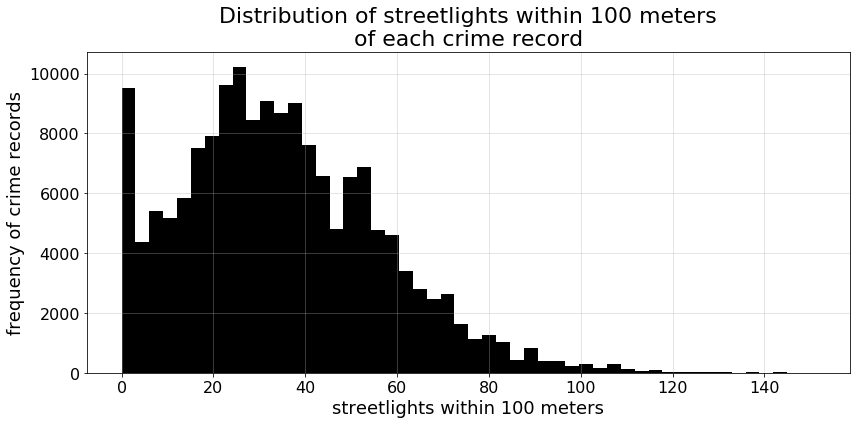

In [30]:
# print summary of calculated streetlight densities by crime record

print(streetlights.shape)

savefig = True

fig, ax = plt.subplots(figsize=(12, 6))

plt.hist(streetlights, color='k', bins=50)
plt.title(
    'Distribution of streetlights within {:,} meters\nof each crime record'.format(threshold),
    fontsize=22
)

ax.tick_params(labelsize=16)
ax.set_ylabel("frequency of crime records", fontsize=18)
ax.set_xlabel("streetlights within {:,} meters".format(threshold), fontsize=18)
ax.grid(':', alpha=0.4)    
plt.tight_layout()
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'streetlights-within-{}-meters-of-crimes.png'.format(threshold)))
plt.show();

In [31]:
# add streetlights feature to crime data
df_crime['streetlights'] = streetlights

In [32]:
df_crime.info()
df_crime.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162533 entries, 0 to 162532
Data columns (total 59 columns):
crime-type                           162533 non-null int64
INCIDENT_NUMBER                      162533 non-null object
OFFENSE_DESCRIPTION                  162533 non-null object
timestamp                            162533 non-null datetime64[ns]
lat                                  162533 non-null float64
lon                                  162533 non-null float64
year                                 162533 non-null object
month                                162533 non-null int64
day-of-week                          162533 non-null object
hour                                 162533 non-null object
ZIP5                                 162509 non-null object
ZIP5_area                            162509 non-null object
Name                                 162460 non-null object
Neighborhood_area                    162460 non-null object
Neighborhood_area_2                  1624

,crime-type,INCIDENT_NUMBER,OFFENSE_DESCRIPTION,timestamp,lat,lon,year,month,day-of-week,hour,...,weathercodes,sunrise,sunset,tempavg,windavg,precip,snowfall,time,night,streetlights
0,3,I192078177,forgery / counterfeiting,2019-08-01 17:46:00,42.304922,-71.102981,2019,8,Thursday,17,...,NaN,436,1904,27.8,7.9,0.00,0.0,1066,0,7
1,4,I192078061,harassment,2019-06-12 21:00:00,42.355553,-71.152747,2019,6,Wednesday,21,...,NaN,407,1921,20.0,11.6,0.00,0.0,1260,0,8
2,6,I192078038,larceny theft of mv parts & accessories,2019-03-10 08:00:00,42.345625,-71.041291,2019,3,Sunday,8,...,RA DZ SN PL FG BR,605,1744,2.2,12.8,0.46,0.9,480,1,26
3,6,I192078015,larceny all others,2019-07-08 10:29:00,42.339304,-71.051604,2019,7,Monday,10,...,NaN,415,1923,21.7,7.8,0.00,0.0,629,0,77
4,6,I192077997,auto theft - leased/rented vehicle,2019-04-13 08:00:00,42.328564,-71.068353,2019,4,Saturday,8,...,RA BR,507,1823,18.9,14.0,0.28,0.0,480,1,17


## Create college proximity feature

In [33]:
df_colleges.info()
df_colleges.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 29 columns):
Unnamed: 0       57 non-null int64
OBJECTID         57 non-null int64
Match_type       57 non-null object
Ref_ID           57 non-null int64
ID1              42 non-null object
Id               57 non-null int64
SchoolId         57 non-null int64
Name             57 non-null object
Address          57 non-null object
City             57 non-null object
Zipcode          55 non-null float64
Contact          57 non-null object
PhoneNumbe       57 non-null object
YearBuilt        57 non-null int64
NumStories       57 non-null object
Cost             57 non-null int64
NumStudent       57 non-null int64
BackupPowe       57 non-null int64
ShelterCap       57 non-null object
Latitude         57 non-null float64
Longitude        57 non-null float64
Comment          57 non-null object
X                57 non-null float64
Y                57 non-null float64
NumStudent12     38 non-null float64


,Unnamed: 0,OBJECTID,Match_type,Ref_ID,ID1,Id,SchoolId,Name,Address,City,...,Latitude,Longitude,Comment,X,Y,NumStudent12,CampusHous,NumStudents13,URL,Address2013
0,0,1,NCES,0,"Fruit St, Boston, Massachusetts 02114-2696",98627,431594,Massachusetts General Hospital Dietetic Intern...,"Fruit St, Boston, Massachusetts 02114",West End,...,42.362591,-71.070141,0300381001,772340.999867,2.957450e+06,NaN,,20,NaN,NaN
1,1,2,NCES & Consortium,0,"8 Ashburton Place, Boston, Massachusetts 02108...",11959,168005,Suffolk University,"8 Ashburton Pl Beacon Hill, Boston, Massachuse...",Boston,...,42.358905,-71.061948,0302802001,774562.025937,2.956118e+06,9101.0,21%,8675,http://www.suffolk.edu,NaN
2,2,3,NCES & Consortium,0,"41 Berkeley St, Boston, Massachusetts 02116",16632,165884,Benjamin Franklin Institute of Technology,"41 Berkeley St, Boston, Massachusetts 02116",South End,...,42.346103,-71.070186,0500688000,772358.914857,2.951441e+06,472.0,,482,http://www.bfit.edu,NaN
3,3,4,NCES & Consortium,0,"250 New Rutherford Ave, Boston, Massachusetts ...",1949,165112,Bunker Hill Community College,"250 New Rutherford Ave, Boston, Massachusetts ...",Charlestown,...,42.375117,-71.069572,0202170000,772471.759776,2.962015e+06,12934.0,,14023,http://www.bhcc.mass.edu,NaN
4,4,5,NCES & Consortium,0,"36 1st Avenue, Boston, Massachusetts 02129-4557",9109,166869,MGH Institute of Health Professions,"36 1st Avenue, Boston, Massachusetts 02129",Charlestown,...,42.374917,-71.053972,0203504000,776687.321227,2.961964e+06,928.0,,1096,http://www.mghihp.edu,NaN


In [34]:
df_colleges.describe()

,Unnamed: 0,OBJECTID,Ref_ID,Id,SchoolId,Zipcode,YearBuilt,Cost,NumStudent,BackupPowe,Latitude,Longitude,X,Y,NumStudent12,NumStudents13,Address2013
count,57.000000,57.000000,57.0,57.000000,5.700000e+01,55.000000,57.000000,5.700000e+01,57.000000,57.0,57.000000,57.000000,57.000000,5.700000e+01,38.000000,57.000000,0.0
mean,28.000000,29.701754,0.0,42449.473684,4.260381e+05,113572.218182,1756.649123,3.810699e+07,2711.894737,0.0,42.344105,-71.092288,766386.991935,2.950685e+06,5140.105263,2627.456140,NaN
std,16.598193,17.085881,0.0,35280.176536,2.189046e+06,133406.639214,550.555871,9.133320e+07,6184.962668,0.0,0.021252,0.027650,7465.578714,7.754472e+03,8215.530661,5436.010486,NaN
min,0.000000,1.000000,0.0,1949.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.0,42.254000,-71.180351,742669.813147,2.917826e+06,98.000000,0.000000,NaN
25%,14.000000,15.000000,0.0,14097.000000,0.000000e+00,33951.000000,1899.000000,3.189600e+06,0.000000,0.0,42.339187,-71.103478,763367.006004,2.948882e+06,495.750000,0.000000,NaN
50%,28.000000,30.000000,0.0,17534.000000,1.656710e+05,67821.000000,1899.000000,8.714400e+06,594.000000,0.0,42.348500,-71.095494,765546.574808,2.952280e+06,1255.000000,698.000000,NaN
75%,42.000000,44.000000,0.0,86223.000000,1.672240e+05,138158.000000,1945.000000,2.681230e+07,1593.000000,0.0,42.351960,-71.070970,772164.999891,2.953518e+06,4739.000000,2264.000000,NaN
max,56.000000,59.000000,0.0,98627.000000,1.664520e+07,606500.000000,1999.000000,5.227396e+08,31960.000000,0.0,42.381010,-71.039202,780798.454737,2.964159e+06,32439.000000,32411.000000,NaN


In [35]:
%%time

# set distance in meters to identify crime proximal to colleges 
threshold = 500

# convert locations to numpy array for calculating distances
college_locs = df_colleges[['Latitude', 'Longitude']].values

# generate array of calculated distances for all crimes to all colleges
college_distances = distance(crime_locs[:, None], college_locs)

# identify minimum distances and associated college populations for each crime
min_idx = np.argmin(college_distances, axis=1)
min_distances = np.min(college_distances, axis=1)
min_populations = df_colleges['NumStudent'].values[min_idx]

# create proximity indicator based on threshold distance
near_college = (min_distances<threshold).astype(int)

CPU times: user 272 ms, sys: 37.5 ms, total: 309 ms
Wall time: 222 ms


In [36]:
print(
    'The number of crimes within {} meters of a college or university is:  {:,}'\
    ''.format(threshold, np.sum(near_college))
)

The number of crimes within 500 meters of a college or university is:  47,207


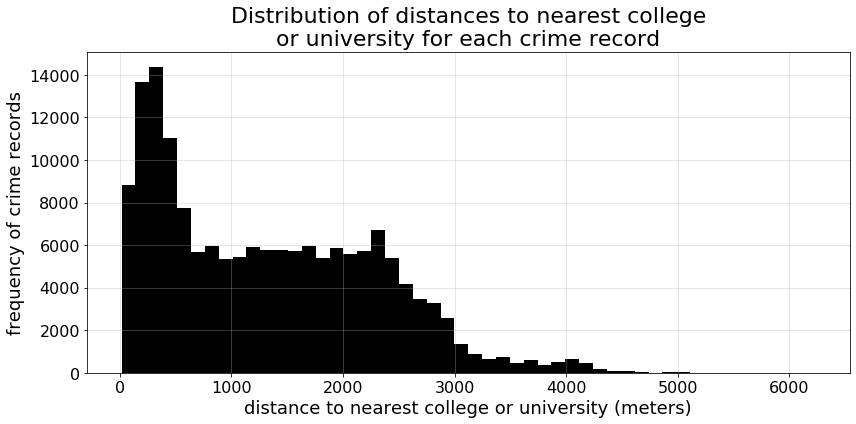

In [37]:
savefig = True

fig, ax = plt.subplots(figsize=(12, 6))

plt.hist(min_distances, color='k', bins=50)
plt.title(
    'Distribution of distances to nearest college\nor university '\
    'for each crime record'.format(threshold),
    fontsize=22
)

ax.tick_params(labelsize=16)
ax.set_ylabel("frequency of crime records", fontsize=18)
ax.set_xlabel("distance to nearest college or university (meters)".format(threshold), fontsize=18)
ax.grid(':', alpha=0.4)    
plt.tight_layout()
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'colleges-nearest-distances-to-crimes.png'.format(threshold)))
plt.show();

In [38]:
df_crime['college-distance'] = min_distances
df_crime['college-near'] = near_college

In [39]:
df_crime.info()
df_crime.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162533 entries, 0 to 162532
Data columns (total 61 columns):
crime-type                           162533 non-null int64
INCIDENT_NUMBER                      162533 non-null object
OFFENSE_DESCRIPTION                  162533 non-null object
timestamp                            162533 non-null datetime64[ns]
lat                                  162533 non-null float64
lon                                  162533 non-null float64
year                                 162533 non-null object
month                                162533 non-null int64
day-of-week                          162533 non-null object
hour                                 162533 non-null object
ZIP5                                 162509 non-null object
ZIP5_area                            162509 non-null object
Name                                 162460 non-null object
Neighborhood_area                    162460 non-null object
Neighborhood_area_2                  1624

,crime-type,INCIDENT_NUMBER,OFFENSE_DESCRIPTION,timestamp,lat,lon,year,month,day-of-week,hour,...,sunset,tempavg,windavg,precip,snowfall,time,night,streetlights,college-distance,college-near
0,3,I192078177,forgery / counterfeiting,2019-08-01 17:46:00,42.304922,-71.102981,2019,8,Thursday,17,...,1904,27.8,7.9,0.00,0.0,1066,0,7,2719.884235,0
1,4,I192078061,harassment,2019-06-12 21:00:00,42.355553,-71.152747,2019,6,Wednesday,21,...,1921,20.0,11.6,0.00,0.0,1260,0,8,1315.155113,0
2,6,I192078038,larceny theft of mv parts & accessories,2019-03-10 08:00:00,42.345625,-71.041291,2019,3,Sunday,8,...,1744,2.2,12.8,0.46,0.9,480,1,26,1543.501741,0
3,6,I192078015,larceny all others,2019-07-08 10:29:00,42.339304,-71.051604,2019,7,Monday,10,...,1923,21.7,7.8,0.00,0.0,629,0,77,1422.033321,0
4,6,I192077997,auto theft - leased/rented vehicle,2019-04-13 08:00:00,42.328564,-71.068353,2019,4,Saturday,8,...,1823,18.9,14.0,0.28,0.0,480,1,17,797.819824,0


## Create high school proximity feature

In [40]:
df_schoolspub.info()
display(df_schoolspub.head())
df_schoolsnonpub.info()
display(df_schoolsnonpub.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 18 columns):
X             131 non-null float64
Y             131 non-null float64
OBJECTID_1    131 non-null int64
OBJECTID      131 non-null int64
BLDG_ID       131 non-null int64
BLDG_NAME     131 non-null object
ADDRESS       131 non-null object
CITY          131 non-null object
ZIPCODE       131 non-null int64
CSP_SCH_ID    131 non-null int64
SCH_ID        131 non-null int64
SCH_NAME      131 non-null object
SCH_LABEL     131 non-null object
SCH_TYPE      131 non-null object
SHARED        131 non-null object
COMPLEX       131 non-null object
POINT_X       131 non-null float64
POINT_Y       131 non-null float64
dtypes: float64(4), int64(6), object(8)
memory usage: 18.5+ KB


,X,Y,OBJECTID_1,OBJECTID,BLDG_ID,BLDG_NAME,ADDRESS,CITY,ZIPCODE,CSP_SCH_ID,SCH_ID,SCH_NAME,SCH_LABEL,SCH_TYPE,SHARED,COMPLEX,POINT_X,POINT_Y
0,-71.004121,42.388799,1,1,1,Guild Bldg,195 Leyden Street,East Boston,2128,4061,4061,Guild Elementary,Guild,ES,,,790128.152748,2.967094e+06
1,-71.030480,42.378545,2,2,3,"Kennedy, P Bldg",343 Saratoga Street,East Boston,2128,4541,4541,Kennedy Patrick Elem,PJ Kennedy,ES,,,783027.745829,2.963318e+06
2,-71.033891,42.375279,3,3,4,Otis Bldg,218 Marion Street,East Boston,2128,4322,4322,Otis Elementary,Otis,ES,,,782112.823908,2.962122e+06
3,-71.038011,42.378089,4,4,6,Odonnell Bldg,33 Trenton Street,East Boston,2128,4543,4543,O'Donnell Elementary,O'Donnell,ES,,,780994.000003,2.963140e+06
4,-71.034921,42.380957,5,5,7,East Boston High Bldg,86 White Street,East Boston,2128,1070,1070,East Boston High,East Boston HS,HS,,,781823.000004,2.964190e+06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 16 columns):
X             82 non-null float64
Y             82 non-null float64
OBJECTID_1    82 non-null int64
OBJECTID      82 non-null int64
SCHID         79 non-null float64
NAME          82 non-null object
ADDRESS       82 non-null object
TOWN_MAIL     82 non-null object
TOWN          82 non-null object
STATE         82 non-null object
ZIP           82 non-null object
PRINCIPAL     82 non-null object
PHONE         82 non-null object
FAX           82 non-null object
GRADES        82 non-null object
TYPE          82 non-null object
dtypes: float64(3), int64(2), object(11)
memory usage: 10.3+ KB


,X,Y,OBJECTID_1,OBJECTID,SCHID,NAME,ADDRESS,TOWN_MAIL,TOWN,STATE,ZIP,PRINCIPAL,PHONE,FAX,GRADES,TYPE
0,-71.105143,42.327676,85,163,5300.0,Roxbury Prep - Mission Hill,120 Fisher Avenue,Roxbury,BOSTON,MA,02120,Dana Lehman,617-566-2361,617-566-2373,"6,7,8",CHA
1,-71.058717,42.301403,86,153,5470.0,Helen Davis Leadership Academy Charter Public ...,23 Leonard Street,Boston,BOSTON,MA,02122,Karmala Sherwood,617-474-7950,617-474-7957,"6,7,8",CHA
2,-71.130150,42.306593,87,1100,350950.0,British School of Boston,416-420 Pond Street,Jamaica Plain,BOSTON,MA,02130,Bruce Robinson,617-522-2261,617-522-0385,"PK,K,1,2,3,4,5,6,7,8,9,10,11,12",PRI
3,-71.095739,42.349346,88,206,5230001.0,EDCO Collaborative - EDCO YOUTH ALT,"650 Beacon St , 3rd Floor",Boston,BOSTON,MA,02215,,617-262-9562,617-262-0098,,COP
4,-71.132132,42.244270,89,134,5600.0,Academy Of the Pacific Rim Charter Public School,1 Westinghouse Plaza,Hyde Park,BOSTON,MA,02136,Jenne Colasacco,617-361-0050,617-361-0045,"5,6,7,8,9,10,11,12",CHA


In [41]:
# subset public schools for only high schools
df_schoolspub = df_schoolspub.loc[
    (df_schoolspub['SCH_TYPE']=='HS') |
    (df_schoolspub['SCH_TYPE']=='6/7-12') | 
    (df_schoolspub['SCH_NAME'].str.contains('HS')) |
    (df_schoolspub['SCH_NAME'].str.contains('12')) |
    (df_schoolspub['SCH_NAME'].str.contains('High'))
]

# subset non-public schools for only high schools
df_schoolsnonpub = df_schoolsnonpub.loc[
    (df_schoolsnonpub['GRADES'].str.contains('12'))
]

# subset and rename columns to match for concatenating dataframes
new_cols = ['school_id', 'name', 'type', 'lat', 'lon', 'address', 'city', 'zip']

df_schoolspub = df_schoolspub[
    ['SCH_ID', 'SCH_NAME', 'SCH_TYPE', 'Y', 'X', 'ADDRESS', 'CITY', 'ZIPCODE']
].copy()

df_schoolspub.columns = new_cols

df_schoolsnonpub = df_schoolsnonpub[
    ['SCHID', 'NAME', 'GRADES', 'Y', 'X', 'ADDRESS', 'TOWN_MAIL', 'ZIP']
].copy()

df_schoolsnonpub.columns = new_cols

# concatenate public and non-public highschools
df_highschools = pd.concat([df_schoolspub, df_schoolsnonpub], ignore_index=True)

# fix school_id datatype and zipcodes
df_highschools['school_id'] = df_highschools['school_id'].astype(int)
df_highschools['zip'] = ('00000' + df_highschools['zip'].astype(str)).str[-5:]

In [42]:
# print concatenated results
df_highschools.info()
df_highschools.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 8 columns):
school_id    53 non-null int64
name         53 non-null object
type         53 non-null object
lat          53 non-null float64
lon          53 non-null float64
address      53 non-null object
city         53 non-null object
zip          53 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 3.4+ KB


,school_id,name,type,lat,lon,address,city,zip
0,1070,East Boston High,HS,42.380957,-71.034921,86 White Street,East Boston,02128
1,1050,Charlestown High,HS,42.380119,-71.061071,240 Medford Street,Charlestown,02129
2,1200,Snowden International,HS,42.350579,-71.077971,150 Newbury Street,Boston,02116
3,1162,Excel High,HS,42.332869,-71.044891,95 G Street,South Boston,02127
4,1256,West Roxbury Academy,HS,42.282269,-71.174341,1205 V.F.W. Parkway,West Roxbury,02132


In [43]:
%%time
# find distance to nearest high school and create proximity indicator
# for each crime record

# set distance in meters to identify crime proximal to colleges 
threshold = 500

# convert locations to numpy array for calculating distances
highschool_locs = df_highschools[['lat', 'lon']].values

# generate array of calculated distances for all crimes to all colleges
highschool_distances = distance(crime_locs[:, None], highschool_locs)

# identify minimum distances and associated college populations for each crime
min_idx = np.argmin(highschool_distances, axis=1)
min_distances = np.min(highschool_distances, axis=1)
min_name = df_highschools['name'].values[min_idx]

# create proximity indicator based on threshold distance
near_highschool = (min_distances<threshold).astype(int)

CPU times: user 291 ms, sys: 62.1 ms, total: 353 ms
Wall time: 215 ms


In [44]:
print(
    'The number of crimes within {} meters of a college or university is:  {:,}'\
    ''.format(threshold, np.sum(near_highschool))
)

The number of crimes within 500 meters of a college or university is:  57,865


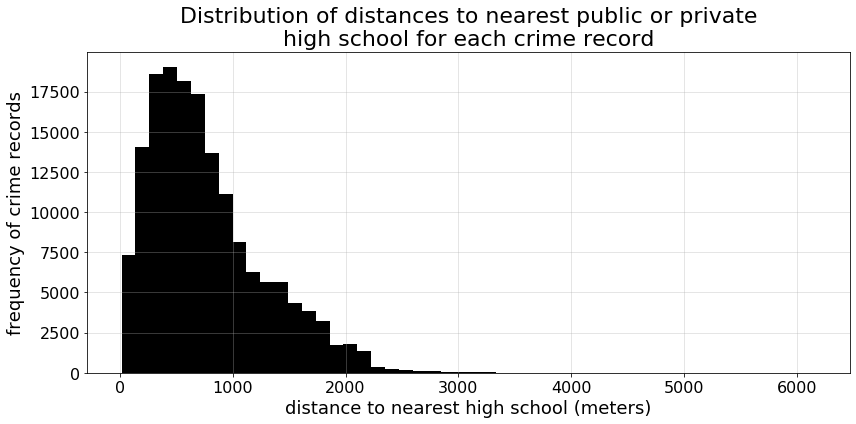

In [45]:
savefig = True

fig, ax = plt.subplots(figsize=(12, 6))

plt.hist(min_distances, color='k', bins=50)
plt.title(
    'Distribution of distances to nearest public or private\nhigh school '\
    'for each crime record'.format(threshold),
    fontsize=22
)

ax.tick_params(labelsize=16)
ax.set_ylabel("frequency of crime records", fontsize=18)
ax.set_xlabel("distance to nearest high school (meters)".format(threshold), fontsize=18)
ax.grid(':', alpha=0.4)    
plt.tight_layout()
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'highschool-nearest-distances-to-crimes.png'.format(threshold)))
plt.show();

In [46]:
df_crime['highschool-distance'] = min_distances
df_crime['highschool-near'] = near_highschool

In [47]:
df_crime.info()
df_crime.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162533 entries, 0 to 162532
Data columns (total 63 columns):
crime-type                           162533 non-null int64
INCIDENT_NUMBER                      162533 non-null object
OFFENSE_DESCRIPTION                  162533 non-null object
timestamp                            162533 non-null datetime64[ns]
lat                                  162533 non-null float64
lon                                  162533 non-null float64
year                                 162533 non-null object
month                                162533 non-null int64
day-of-week                          162533 non-null object
hour                                 162533 non-null object
ZIP5                                 162509 non-null object
ZIP5_area                            162509 non-null object
Name                                 162460 non-null object
Neighborhood_area                    162460 non-null object
Neighborhood_area_2                  1624

,crime-type,INCIDENT_NUMBER,OFFENSE_DESCRIPTION,timestamp,lat,lon,year,month,day-of-week,hour,...,windavg,precip,snowfall,time,night,streetlights,college-distance,college-near,highschool-distance,highschool-near
0,3,I192078177,forgery / counterfeiting,2019-08-01 17:46:00,42.304922,-71.102981,2019,8,Thursday,17,...,7.9,0.00,0.0,1066,0,7,2719.884235,0,557.631565,0
1,4,I192078061,harassment,2019-06-12 21:00:00,42.355553,-71.152747,2019,6,Wednesday,21,...,11.6,0.00,0.0,1260,0,8,1315.155113,0,760.669282,0
2,6,I192078038,larceny theft of mv parts & accessories,2019-03-10 08:00:00,42.345625,-71.041291,2019,3,Sunday,8,...,12.8,0.46,0.9,480,1,26,1543.501741,0,837.894451,0
3,6,I192078015,larceny all others,2019-07-08 10:29:00,42.339304,-71.051604,2019,7,Monday,10,...,7.8,0.00,0.0,629,0,77,1422.033321,0,903.657571,0
4,6,I192077997,auto theft - leased/rented vehicle,2019-04-13 08:00:00,42.328564,-71.068353,2019,4,Saturday,8,...,14.0,0.28,0.0,480,1,17,797.819824,0,985.466816,0


## Create demographics features

In [48]:
df_demographics.info()
df_demographics.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 73 columns):
Unnamed: 0                                      23 non-null int64
Location                                        23 non-null object
Total-Population_x                              23 non-null float64
Median-Age                                      23 non-null float64
0:9-Years                                       23 non-null float64
0:9-Percentage                                  23 non-null float64
10:19-Years                                     23 non-null float64
10:19-Percentage                                23 non-null float64
20:34-Years                                     23 non-null float64
20:34-Percentage                                23 non-null float64
35:54-Years                                     23 non-null float64
35:54-Percentage                                23 non-null float64
55-64 years                                     23 non-null float64
55:64-Percentage

,Unnamed: 0,Location,Total-Population_x,Median-Age,0:9-Years,0:9-Percentage,10:19-Years,10:19-Percentage,20:34-Years,20:34-Percentage,...,Enrolled-Grade-5:8,Enrolled-Grade-5:8-Percentage,Enrolled-Grade-9:12,Enrolled-Grade-9:12-Percentage,Enrolled-College-Undergraduate,Enrolled-College-Undergraduate-Percentage,Graduate-Or-Professional-School,Graduate-Or-Professional-School-Percentage,Not-Enrolled-In-School,Not-Enrolled-In-School-Percentage
0,0,Allston,19363.0,26.0,550.0,0.028405,2691.0,0.138976,13084.0,0.675722,...,162.0,0.014313,77.0,0.006803,6630.0,0.585793,4106.0,0.362785,7856.0,0.409721
1,1,Back Bay,18176.0,33.0,798.0,0.043904,1632.0,0.089789,7498.0,0.412522,...,227.0,0.050965,171.0,0.038392,2321.0,0.521105,1293.0,0.290301,13366.0,0.750056
2,2,Beacon Hill,9751.0,32.0,728.0,0.074659,322.0,0.033022,4758.0,0.487950,...,67.0,0.044548,71.0,0.047207,503.0,0.334441,459.0,0.305186,7844.0,0.839110
3,3,Brighton,51785.0,29.0,3271.0,0.063165,3244.0,0.062644,27399.0,0.529091,...,791.0,0.051444,950.0,0.061785,7140.0,0.464360,4950.0,0.321930,35071.0,0.695205
4,4,Charlestown,18901.0,35.0,2424.0,0.128247,1196.0,0.063277,5738.0,0.303582,...,557.0,0.173035,416.0,0.129233,552.0,0.171482,512.0,0.159056,14683.0,0.820188


In [49]:
# create feature to measure total college enrollment percentage by neighborhood
df_demographics['Enrolled-college-percentage'] = df_demographics['Graduate-Or-Professional-School-Percentage'] + \
                                                 df_demographics['Enrolled-College-Undergraduate-Percentage']

In [50]:
# identify differences in neighborhood sets in demo vs. crime data
hoods_crime_list = list(df_crime['Name'].value_counts(dropna=False).sort_index().index)[:-1]
hoods_demo_list = list(df_demographics['Location'].values)
print('The following nighborhoods are in the crime data, but not the demographics data:')
display(set(hoods_crime_list) - set(hoods_demo_list))
print('And vice versa:')
display(set(hoods_demo_list) - set(hoods_crime_list))

The following nighborhoods are in the crime data, but not the demographics data:


{'Bay Village', 'Chinatown', 'Leather District'}

And vice versa:


set()

In [51]:
# create match key for crime data neighborhoods vs. 
# demographics data neighborhoods
# leave blank values with not key match
neighborhood_match_dict = {
    name: name if name in hoods_demo_list else np.nan
    for name in hoods_crime_list

}

# add missing key matches, with most appropriate available match
neighborhood_match_dict['Bay Village'] = 'Back Bay'
neighborhood_match_dict['Chinatown'] = 'Downtown'
neighborhood_match_dict['Leather District'] = 'Downtown'

# review match dict
print(neighborhood_match_dict)

{'Allston': 'Allston', 'Back Bay': 'Back Bay', 'Bay Village': 'Back Bay', 'Beacon Hill': 'Beacon Hill', 'Brighton': 'Brighton', 'Charlestown': 'Charlestown', 'Chinatown': 'Downtown', 'Dorchester': 'Dorchester', 'Downtown': 'Downtown', 'East Boston': 'East Boston', 'Fenway': 'Fenway', 'Harbor Islands': 'Harbor Islands', 'Hyde Park': 'Hyde Park', 'Jamaica Plain': 'Jamaica Plain', 'Leather District': 'Downtown', 'Longwood': 'Longwood', 'Mattapan': 'Mattapan', 'Mission Hill': 'Mission Hill', 'North End': 'North End', 'Roslindale': 'Roslindale', 'Roxbury': 'Roxbury', 'South Boston': 'South Boston', 'South Boston Waterfront': 'South Boston Waterfront', 'South End': 'South End', 'West End': 'West End', 'West Roxbury': 'West Roxbury'}


In [52]:
# create temporary neighborhood match column
# and add column to drop list for later removal
temp_drop_list = temp_drop_list + ['demo_neighborhood']

df_crime['demo_neighborhood'] = df_crime['Name'].copy().map(neighborhood_match_dict)

# check map value results
print(
    'nan values for each name column are {} and {}'.format(
        df_crime['demo_neighborhood'].isnull().sum(),
        df_crime['Name'].isnull().sum()
    )
)
df_crime.groupby(['demo_neighborhood', 'Name']).agg({'INCIDENT_NUMBER': 'count'})

nan values for each name column are 73 and 73


INCIDENT_NUMBER
demo_neighborhood       Name                                    
Allston                 Allston                             4390
Back Bay                Back Bay                            8392
                        Bay Village                          441
Beacon Hill             Beacon Hill                         1328
Brighton                Brighton                            5240
Charlestown             Charlestown                         2872
Dorchester              Dorchester                         39907
Downtown                Chinatown                           1635
                        Downtown                           12544
                        Leather District                     277
East Boston             East Boston                         6518
Fenway                  Fenway                              5141
Harbor Islands          Harbor Islands                         2
Hyde Park               Hyde Park                           6234
Jamaica Plain           Jamaica Plain                       7714
Longwood                Longwood                             664
Mattapan                Mattapan                            7467
Mission Hill            Mission Hill                        3301
North End               North End                           1277
Roslindale              Roslindale                          4369
Roxbury                 Roxbury                            21639
South Boston            South Boston                        8026
South Boston Waterfront South Boston Waterfront              878
South End               South End                           7294
West End                West End                            1782
West Roxbury            West Roxbury                        3128

In [53]:
############################################
# MATCH DEMOGRAPHICS VALUES TO CRIME RECORDS
############################################

# define demographics to include in crime data
demographics_columns_list = [
    'Median-Income',
    'Poverty-Rate',
    'Less-Than-High-School-Percentage',
    'Bachelor-Degree-Or-More-Percentage',
    'Median-Age',
    'Enrolled-college-percentage'
]

# define names of new features
demographics_feature_names = [
    'median-income',
    'poverty-rate',
    'less-than-high-school-perc',
    'bachelor-degree-or-more-perc',
    'median-age',
    'enrolled-college-perc'
]

# map every crime record to the corresponding demographic features
for column, feature in zip(demographics_columns_list, demographics_feature_names):
    temp_match_dict = dict(
        zip(
            df_demographics[['Location', column]].values[:, 0],
            df_demographics[['Location', column]].values[:, 1]
        )
    )
    df_crime[feature] = df_crime['demo_neighborhood'].copy().map(temp_match_dict)

In [54]:
# check results
df_crime.info()
df_crime.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162533 entries, 0 to 162532
Data columns (total 70 columns):
crime-type                           162533 non-null int64
INCIDENT_NUMBER                      162533 non-null object
OFFENSE_DESCRIPTION                  162533 non-null object
timestamp                            162533 non-null datetime64[ns]
lat                                  162533 non-null float64
lon                                  162533 non-null float64
year                                 162533 non-null object
month                                162533 non-null int64
day-of-week                          162533 non-null object
hour                                 162533 non-null object
ZIP5                                 162509 non-null object
ZIP5_area                            162509 non-null object
Name                                 162460 non-null object
Neighborhood_area                    162460 non-null object
Neighborhood_area_2                  1624

,crime-type,INCIDENT_NUMBER,OFFENSE_DESCRIPTION,timestamp,lat,lon,year,month,day-of-week,hour,...,college-near,highschool-distance,highschool-near,demo_neighborhood,median-income,poverty-rate,less-than-high-school-perc,bachelor-degree-or-more-perc,median-age,enrolled-college-perc
0,3,I192078177,forgery / counterfeiting,2019-08-01 17:46:00,42.304922,-71.102981,2019,8,Thursday,17,...,0,557.631565,0,Roxbury,27721.35,0.338628,0.242741,0.222312,32.0,0.416269
1,4,I192078061,harassment,2019-06-12 21:00:00,42.355553,-71.152747,2019,6,Wednesday,21,...,0,760.669282,0,Brighton,62041.20,0.199045,0.086768,0.650441,29.0,0.786290
2,6,I192078038,larceny theft of mv parts & accessories,2019-03-10 08:00:00,42.345625,-71.041291,2019,3,Sunday,8,...,0,837.894451,0,South Boston Waterfront,150677.51,0.054675,0.020694,0.819760,33.0,0.700935
3,6,I192078015,larceny all others,2019-07-08 10:29:00,42.339304,-71.051604,2019,7,Monday,10,...,0,903.657571,0,South Boston,93077.60,0.163187,0.092258,0.614009,32.0,0.398005
4,6,I192077997,auto theft - leased/rented vehicle,2019-04-13 08:00:00,42.328564,-71.068353,2019,4,Saturday,8,...,0,985.466816,0,Roxbury,27721.35,0.338628,0.242741,0.222312,32.0,0.416269


In [55]:
# review temp drop list created during feature merge
temp_drop_list

['tract-match-key', 'date', 'time', 'sunrise', 'sunset', 'demo_neighborhood']

## Drop unwanted columns and observations with missing predictor values

In [56]:
# create final drop columns list
drop_columns_list = [
    'tract-match-key',
    'sunrise',
    'sunset',
    'demo_neighborhood',
    'month-cat',
    'day-of-week',
    'timestamp',
]

# drop columns
df_crime = df_crime.drop(columns=drop_columns_list)

In [57]:
# check remaining columns
print(list(df_crime.columns))

['crime-type', 'INCIDENT_NUMBER', 'OFFENSE_DESCRIPTION', 'lat', 'lon', 'year', 'month', 'hour', 'ZIP5', 'ZIP5_area', 'Name', 'Neighborhood_area', 'Neighborhood_area_2', 'TRACTCE10', 'TRACTCE10_area', 'TRACTCE10_area_2', 'crime-type-cat', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'commercial-mix-ratio', 'industrial-mix-ratio', 'owner-occupied-ratio', 'residential-gini-coef', 'residential-median-value', 'commercial-mix-ratio-3yr-cagr', 'industrial-mix-ratio-3yr-cagr', 'owner-occupied-ratio-3yr-cagr', 'residential-median-value-3yr-cagr', 'residential-gini-coef-3yr-cagr', 'date', 'weathercodes', 'tempavg', 'windavg', 'precip', 'snowfall', 'time', 'night', 'streetlights', 'college-distance', 'college-near', 'highschool-distance', 'highschool-near', 'median-income', 'poverty-rate', 'less-than-high-school-perc', 'bachelor-degree-or-more-perc', 'median-age', 'enrolled-college-perc']


In [58]:
# drop observations with missing predictor values, ignore non-predictor columns
ignore_na_cols = [
    'weathercodes',
    'ZIP5',
    'ZIP5_area',
    'Name',
    'Neighborhood_area',
    'Neighborhood_area_2',
    'TRACTCE10',
    'TRACTCE10_area',
    'TRACTCE10_area_2',
]

df_crime = df_crime.dropna(
    subset=[col for col in list(df_crime.columns) if col not in ignore_na_cols]
)

In [59]:
# check resulting dataframe
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160440 entries, 0 to 162532
Data columns (total 63 columns):
crime-type                           160440 non-null int64
INCIDENT_NUMBER                      160440 non-null object
OFFENSE_DESCRIPTION                  160440 non-null object
lat                                  160440 non-null float64
lon                                  160440 non-null float64
year                                 160440 non-null object
month                                160440 non-null int64
hour                                 160440 non-null object
ZIP5                                 160440 non-null object
ZIP5_area                            160440 non-null object
Name                                 160440 non-null object
Neighborhood_area                    160440 non-null object
Neighborhood_area_2                  160440 non-null object
TRACTCE10                            160440 non-null object
TRACTCE10_area                       160440 non-n

# Generate train-test-splits of dataset

In [60]:
#########################################
## GENERATE SPLITS
#########################################
np.random.seed(10)

X_train, X_test, y_train, y_test = train_test_split(
    df_crime.drop(columns=['crime-type']), 
    df_crime['crime-type'],
    test_size=0.2,
    random_state = 109, 
    stratify = df_crime['crime-type']
)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(128352, 62)
(32088, 62)
(128352,)
(32088,)


In [61]:
# add category names to y frames for use in later analyses and drop from X frames 
y_train_cols = ['crime-type-cat', 'OFFENSE_DESCRIPTION', 'INCIDENT_NUMBER']

y_train = pd.concat([y_train, X_train[y_train_cols]], axis=1).reset_index(drop=True)
y_test = pd.concat([y_test, X_test[y_train_cols]], axis=1).reset_index(drop=True)
X_train = X_train.drop(columns=y_train_cols).reset_index(drop=True)
X_test = X_test.drop(columns=y_train_cols).reset_index(drop=True)

display(y_train.head(2))
display(y_test.head(2))

,crime-type,crime-type-cat,OFFENSE_DESCRIPTION,INCIDENT_NUMBER
0,4,harassment-disturbance,disorderly conduct,I172097938
1,1,burglary,burglary - commerical - no force,I192046738


,crime-type,crime-type-cat,OFFENSE_DESCRIPTION,INCIDENT_NUMBER
0,8,violence-aggression,assault simple - battery,I182037961
1,3,fraud,fraud - false pretense / scheme,I182024675


## Create standardized version of feature set

In [62]:
def standardize_features(train_df, val_df, exclude_scale_cols):
    """
    Scales val_df features based on train_df mean and std for each feature
    and returns the scaled dataframe. To specify features not to scale,
    use the exclude_scale_cols parameter
    
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param exclude_scale_cols: Optional list containing names of columns we
                               do not wish to scale
    :return: a feature-scaled version of the val_df dataframe, and standard
             scaler fitted object used to scale values
    """
    # create list of non-binary column names for scaling
    scaled_columns = train_df.columns.difference(exclude_scale_cols)
    
    # create StandardScaler instance fitted on non-binary train data
    Scaler = StandardScaler().fit(
        train_df[scaled_columns]
    )
    
    # scale val_df and convert to dataframe with column names
    scaled_df = pd.DataFrame(
        Scaler.transform(val_df[scaled_columns]),
        columns=scaled_columns,
    )
    
    # merge scaled columns with unscaled columns
    scaled_df = pd.concat(
        [
            val_df.drop(scaled_columns, axis=1).reset_index(drop=True),
            scaled_df.copy()
        ],
        axis=1,
    )
    # Return full dataframe and fitted Scaler object
    return scaled_df, Scaler

In [63]:
# Identify columns to exclude from scaling (i.e. binary and non-predictor columns)
exclude_scale_cols = [
    *weekdays_list,
    *months_col_order,
    'night',
    'college-near',
    'highschool-near',
    'date',
    'time',
    'weathercodes',
    'year',
    'month',
    'hour',
    'ZIP5',
    'ZIP5_area',
    'Name',
    'Neighborhood_area',
    'Neighborhood_area_2',
    'TRACTCE10',
    'TRACTCE10_area',
    'TRACTCE10_area_2'
]

In [64]:
#######################################
# CREATE SCALED DATAFRAMES
#######################################

# Perform standard scaling on both X_train and X_test data, fitting X_train as the
# scaler for both
X_train_scaled, Scaler = standardize_features(
    X_train, X_train,
    exclude_scale_cols)

X_test_scaled, Scaler = standardize_features(
    X_train, X_test,
    exclude_scale_cols)

In [65]:
# create X_scaler dataframe for restoring stored values later on in analysis
X_scaler = pd.DataFrame(
    np.hstack([
        np.array(X_train_scaled.drop(columns=exclude_scale_cols).columns).reshape(-1,1),
        Scaler.scale_.reshape(-1,1),
        Scaler.mean_.reshape(-1,1)
    ]),
    columns=['scaled-feature', 'std', 'mean']
)

# check results
X_scaler.info()
X_scaler.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
scaled-feature    25 non-null object
std               25 non-null object
mean              25 non-null object
dtypes: object(3)
memory usage: 680.0+ bytes


,scaled-feature,std,mean
0,bachelor-degree-or-more-perc,0.22372,0.446553
1,college-distance,969.663,1331.48
2,commercial-mix-ratio,0.196608,0.140898
3,commercial-mix-ratio-3yr-cagr,0.120576,-0.0159869
4,enrolled-college-perc,0.237532,0.488762


 ## Add a `streetlight-night` interaction term

In [66]:
###########################################
# add streetlights interaction term feature
###########################################
feature_name = 'streetlights-night'

X_train[feature_name] = X_train['streetlights'] * X_train['night']
X_test[feature_name] = X_test['streetlights'] * X_test['night']

X_train_scaled[feature_name] = X_train_scaled['streetlights'] * X_train_scaled['night']
X_test_scaled[feature_name] = X_test_scaled['streetlights'] * X_test_scaled['night']

# add scaling to X_scaler dataframe
X_scaler = X_scaler.append(
    {
        'scaled-feature': feature_name,
        'std': X_scaler.loc[X_scaler['scaled-feature']=='streetlights']['std'].values[0],
        'mean': X_scaler.loc[X_scaler['scaled-feature']=='streetlights']['mean'].values[0]
    },
    ignore_index=True
)

In [67]:
# review final split frame shapes
print(X_train.shape)
print(X_test.shape)
print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(y_train.shape)
print(y_test.shape)
print(X_scaler.shape)

(128352, 60)
(32088, 60)
(128352, 60)
(32088, 60)
(128352, 4)
(32088, 4)
(26, 3)


## Sort final dataframe columns and save to disk

In [68]:
# view final columns remaining in X frames
list(X_train.columns)

['lat',
 'lon',
 'year',
 'month',
 'hour',
 'ZIP5',
 'ZIP5_area',
 'Name',
 'Neighborhood_area',
 'Neighborhood_area_2',
 'TRACTCE10',
 'TRACTCE10_area',
 'TRACTCE10_area_2',
 'Tuesday',
 'Wednesday',
 'Thursday',
 'Friday',
 'Saturday',
 'Sunday',
 'Feb',
 'Mar',
 'Apr',
 'May',
 'Jun',
 'Jul',
 'Aug',
 'Sep',
 'Oct',
 'Nov',
 'Dec',
 'commercial-mix-ratio',
 'industrial-mix-ratio',
 'owner-occupied-ratio',
 'residential-gini-coef',
 'residential-median-value',
 'commercial-mix-ratio-3yr-cagr',
 'industrial-mix-ratio-3yr-cagr',
 'owner-occupied-ratio-3yr-cagr',
 'residential-median-value-3yr-cagr',
 'residential-gini-coef-3yr-cagr',
 'date',
 'weathercodes',
 'tempavg',
 'windavg',
 'precip',
 'snowfall',
 'time',
 'night',
 'streetlights',
 'college-distance',
 'college-near',
 'highschool-distance',
 'highschool-near',
 'median-income',
 'poverty-rate',
 'less-than-high-school-perc',
 'bachelor-degree-or-more-perc',
 'median-age',
 'enrolled-college-perc',
 'streetlights-night']

In [69]:
# define column sort order for X frames
column_sort_order = [
    'date',
    'year',
    'month',
    'hour',
    'time',
    'ZIP5',
    'ZIP5_area',
    'Name',
    'Neighborhood_area',
    'Neighborhood_area_2',
    'TRACTCE10',
    'TRACTCE10_area',
    'TRACTCE10_area_2',
    'weathercodes',
    'college-distance',
    'highschool-distance',
    'streetlights',
    'streetlights-night',    
    'lat',
    'lon',
    'night',
    'tempavg',
    'windavg',
    'precip',
    'snowfall',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday',
    'Sunday',
    'Feb',
    'Mar',
    'Apr',
    'May',
    'Jun',
    'Jul',
    'Aug',
    'Sep',
    'Oct',
    'Nov',
    'Dec',
    'college-near',
    'highschool-near',
    'median-age',
    'median-income',
    'poverty-rate',
    'less-than-high-school-perc',
    'bachelor-degree-or-more-perc',
    'enrolled-college-perc',
    'commercial-mix-ratio',
    'industrial-mix-ratio',
    'owner-occupied-ratio',
    'residential-median-value',
    'residential-gini-coef',
    'commercial-mix-ratio-3yr-cagr',
    'industrial-mix-ratio-3yr-cagr',
    'owner-occupied-ratio-3yr-cagr',
    'residential-gini-coef-3yr-cagr',
    'residential-median-value-3yr-cagr',
]

In [70]:
##################################
# SORT COLUMNS IN ALL X FRAMES
##################################

X_train = X_train[column_sort_order]
X_test_scaled = X_test_scaled[column_sort_order]
X_train_scaled = X_train_scaled[column_sort_order]
X_test_scaled = X_test_scaled[column_sort_order]

In [71]:
# view info for resulting frame sorted
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128352 entries, 0 to 128351
Data columns (total 60 columns):
date                                 128352 non-null object
year                                 128352 non-null object
month                                128352 non-null int64
hour                                 128352 non-null object
time                                 128352 non-null int64
ZIP5                                 128352 non-null object
ZIP5_area                            128352 non-null object
Name                                 128352 non-null object
Neighborhood_area                    128352 non-null object
Neighborhood_area_2                  128352 non-null object
TRACTCE10                            128352 non-null object
TRACTCE10_area                       128352 non-null object
TRACTCE10_area_2                     128352 non-null object
weathercodes                         62450 non-null object
college-distance                     128352 non-null

In [72]:
##############################################
# SAVE RESULTING DATAFRAMES FOR MODEL BUILDING
##############################################
save_frame_names = [
    'X_train',
    'X_train_scaled',
    'X_test',
    'X_test_scaled',
    'y_train',
    'y_test',
    'X_scaler'
]

for frame_name in save_frame_names:
    globals()[frame_name].to_csv(
        os.path.join(FEATURES_ROOT, ''.join([frame_name, '.csv'])),
        index=False
    )